In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import os
import zipfile
import matplotlib.pyplot as plt
!pip install histdata
from histdata import download_hist_data as dl
from histdata.api import Platform, TimeFrame

In [2]:

dl(
    year="2021",
    month=None,
    pair="BCOUSD",                
    platform=Platform.GENERIC_ASCII,
    time_frame=TimeFrame.ONE_MINUTE
)


zip_name = "DAT_ASCII_BCOUSD_M1_2021.zip"
output_folder = "Brent_2021"
if not os.path.exists(zip_name):
    raise FileNotFoundError(f"Missing {zip_name}")
os.makedirs(output_folder, exist_ok=True)
with zipfile.ZipFile(zip_name, "r") as zf:
    zf.extractall(path=output_folder)


csv_path = os.path.join(output_folder, "DAT_ASCII_BCOUSD_M1_2021.csv")
col_names = ["DateTime","Open","High","Low","Close","Volume"]
stocks_df = pd.read_csv(
    csv_path,
    sep=";",
    header=None,
    names=col_names,
    parse_dates=["DateTime"],
    date_parser=lambda x: pd.to_datetime(x, format="%Y%m%d %H%M%S"),
    index_col="DateTime"
)

print("Brent 2021 1-min data:", stocks_df.shape)
print(stocks_df.head())


https://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/bcousd/2021
{'tk': 'a82144730d51e98a70a2cc040c3307f2', 'date': '2021', 'datemonth': '2021', 'platform': 'ASCII', 'timeframe': 'M1', 'fxpair': 'BCOUSD'}
Wrote to .\DAT_ASCII_BCOUSD_M1_2021.zip


C:\Users\zareb\AppData\Local\Temp\ipykernel_13756\3409263498.py:21: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  stocks_df = pd.read_csv(


Brent 2021 1-min data: (321327, 5)
                       Open    High     Low   Close  Volume
DateTime                                                   
2021-01-03 20:00:00  51.658  51.728  51.658  51.708       0
2021-01-03 20:01:00  51.698  51.738  51.683  51.708       0
2021-01-03 20:02:00  51.713  51.758  51.708  51.753       0
2021-01-03 20:03:00  51.758  51.758  51.743  51.753       0
2021-01-03 20:04:00  51.748  51.768  51.743  51.753       0


In [3]:
stocks_df["Log Price"] = np.log(stocks_df["Close"])
stocks_df["Log Return"] = stocks_df["Log Price"].diff()
stocks_df["Abs Return"] = stocks_df["Log Return"].abs()
stocks_df.head()

,Open,High,Low,Close,Volume,Log Price,Log Return,Abs Return
DateTime,,,,,,,,
2021-01-03 20:00:00,51.658,51.728,51.658,51.708,0,3.945613,NaN,NaN
2021-01-03 20:01:00,51.698,51.738,51.683,51.708,0,3.945613,0.00000,0.00000
2021-01-03 20:02:00,51.713,51.758,51.708,51.753,0,3.946482,0.00087,0.00087
2021-01-03 20:03:00,51.758,51.758,51.743,51.753,0,3.946482,0.00000,0.00000
2021-01-03 20:04:00,51.748,51.768,51.743,51.753,0,3.946482,0.00000,0.00000


In [4]:
stocks_df = stocks_df.dropna(subset=["Log Return"])

In [5]:

stocks_df = stocks_df.loc[:, ~stocks_df.columns.duplicated()]

print(stocks_df.head())
stocks_df = stocks_df.sort_index()
t0 = stocks_df.index.min()


stocks_df["Minute Num"] = ((stocks_df.index - t0).total_seconds() // 60).astype(int)
print(stocks_df[["Minute Num"]].head())


                       Open    High     Low   Close  Volume  Log Price  \
DateTime                                                                 
2021-01-03 20:01:00  51.698  51.738  51.683  51.708       0   3.945613   
2021-01-03 20:02:00  51.713  51.758  51.708  51.753       0   3.946482   
2021-01-03 20:03:00  51.758  51.758  51.743  51.753       0   3.946482   
2021-01-03 20:04:00  51.748  51.768  51.743  51.753       0   3.946482   
2021-01-03 20:05:00  51.758  51.788  51.758  51.768       0   3.946772   

                     Log Return  Abs Return  
DateTime                                     
2021-01-03 20:01:00     0.00000     0.00000  
2021-01-03 20:02:00     0.00087     0.00087  
2021-01-03 20:03:00     0.00000     0.00000  
2021-01-03 20:04:00     0.00000     0.00000  
2021-01-03 20:05:00     0.00029     0.00029  
                     Minute Num
DateTime                       
2021-01-03 20:01:00           0
2021-01-03 20:02:00           1
2021-01-03 20:03:00           2

In [6]:
Lookback, Threshold_Q = 200, 0.995


stocks_df["Rolling Q"] = stocks_df["Abs Return"].rolling(window=Lookback, min_periods=1).quantile(Threshold_Q)
stocks_df.head()

events_df = stocks_df.loc[stocks_df["Abs Return"] > stocks_df["Rolling Q"]].copy()
events_df = events_df.sort_values("DateTime")
events_df.head()

,Open,High,Low,Close,Volume,Log Price,Log Return,Abs Return,Minute Num,Rolling Q
DateTime,,,,,,,,,,
2021-01-03 20:02:00,51.713,51.758,51.708,51.753,0,3.946482,0.000870,0.000870,1,0.000866
2021-01-03 20:06:00,51.773,51.838,51.773,51.833,0,3.948027,0.001255,0.001255,5,0.001245
2021-01-03 21:56:00,52.203,52.572,52.203,52.453,0,3.959918,0.004682,0.004682,115,0.002711
2021-01-04 01:01:00,52.643,53.143,52.633,53.013,0,3.970537,0.006909,0.006909,300,0.004693
2021-01-04 04:31:00,52.858,52.858,52.583,52.593,0,3.962583,-0.005121,0.005121,510,0.003211


In [7]:
event_times = events_df["Minute Num"].values
event_marks = events_df["Abs Return"].values
print(event_times[:5])
print(event_marks[:5])

[  1   5 115 300 510]
[0.00086989 0.00125481 0.00468179 0.00690892 0.00512063]


In [8]:
T_max = event_times.max()
M0 = event_marks.min()
N = len(event_times)
print(N)

2090


In [9]:
def ETAS_loglikelihood(params, event_times, event_marks, T_max, M0):
    mu, K, c, p, alpha = params
    if mu <= 0 or K <= 0 or c <= 0 or p <= 0 or alpha < 0:
        return "Constrate broken"
    t = event_times
    m = event_marks
    N = len(t)
    w = np.exp(alpha * (m - M0))
    C = np.zeros(N)
    A = np.zeros(N)
    C[0] = w[0] * (c ** (-p))
    A[0] = C[0] - w[0] * (c ** (-p))
    for i in range(1, N):
        d_i = t[i] - t[i - 1]
        C[i] = w[i] * (c ** (-p)) + (((c + d_i) / c) ** (-p)) * (C[i - 1] - w[i - 1] * (c ** (-p)))
        A[i] = C[i] - w[i] * (c ** (-p))
    lam_vals = mu + K * A
    if np.any(lam_vals <= 0):
        return np.inf
    pointwise_term = np.sum(np.log(lam_vals))
    def closed_form_I(delta, c, p):
        if abs(p - 1.0) < 1e-8:
            return np.log((delta + c) / c)
        else:
            return ((delta + c) ** (1.0 - p) - c ** (1.0 - p)) / (1.0 - p)
    sum_wI = 0.0
    for i in range(N):
        delta = T_max - t[i]
        if delta < 0:
            return np.inf
        I_i = closed_form_I(delta, c, p)
        sum_wI += w[i] * I_i

    integral_term = mu * T_max + K * sum_wI
    negloglik = -(pointwise_term - integral_term)
    return negloglik


    
    

In [10]:
initial_mu    = max(1e-6, len(event_times) / T_max / 2.0)
initial_K     = 1.0
initial_c     = 0.1 * np.mean(np.diff(event_times)) if len(event_times) > 1 else 0.1
initial_p     = 1.1
initial_alpha = 0.5
params = np.array([initial_mu, initial_K, initial_c, initial_p, initial_alpha])

final_likelihood = ETAS_loglikelihood(params, event_times, event_marks, T_max, M0)
print(final_likelihood)

test_params = np.array([1e-6, 1.0, 1.0, 1.0, 0.0])
print(ETAS_loglikelihood(test_params, event_times, event_marks, T_max, M0))

22954.264660562836
54281.34775356777


In [11]:
bounds = [(1e-12, None),(1e-12, None),(1e-12, None),(1e-12, 10.0),(0.0,5.0)]
res = minimize(ETAS_loglikelihood,params,args=(event_times, event_marks, T_max, M0),method="L-BFGS-B",bounds=bounds,options={"maxiter": 1000})
if res.success:
    mu_hat, K_hat, c_hat, p_hat, alpha_hat = res.x
    print("Fitted parameters:")
    print(f"  μ     = {mu_hat:.4f}")
    print(f"  K     = {K_hat:.4f}")
    print(f"  c     = {c_hat:.4f}")
    print(f"  p     = {p_hat:.4f}")
    print(f"  α     = {alpha_hat:.4f}")
    
else:
    print("Optimization failed:", res.message)

Fitted parameters:
  μ     = 0.0040
  K     = 0.4932
  c     = 24.9478
  p     = 4.1717
  α     = 0.4992


In [12]:
#et = event_times  # sorted ascending

# 2) Compute inter‐event gaps
#gaps = np.diff(et)   # length = N_events - 1

# 3) Whenever gap > 20, declare a new cluster
#max_gap = 20  # minutes
#cluster_ids = np.zeros_like(et, dtype=int)
#cluster_id = 0
#for i in range(1, len(et)):
#    if et[i] - et[i-1] > max_gap:
#        cluster_id += 1
  #  cluster_ids[i] = cluster_id

# 4) Count how many events per cluster
#import pandas as pd
#df_clusters = pd.DataFrame({"cluster": cluster_ids})
#cluster_sizes = df_clusters["cluster"].value_counts().sort_index()

# 5) Plot histogram of cluster sizes
#plt.figure(figsize=(5, 3))
#plt.bar(cluster_sizes.index, cluster_sizes.values, color="tab:purple")
#plt.xlabel("Cluster ID")
#plt.ylabel("Size (number of events)")
#plt.title(f"Cluster Sizes (gap > {max_gap} min)")
#plt.show()

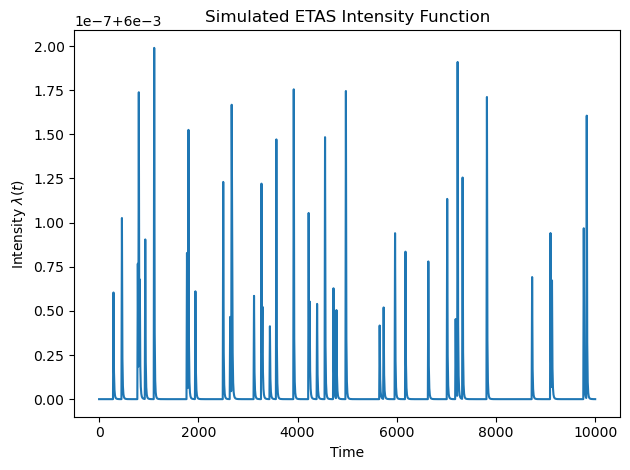

In [13]:
mu =0.006
      # background rate
K = 2
        # productivity
c = 25
 # time offset
p = 5
       # decay exponent

T_max = 10000.0    # total simulation time
events = []       # list to hold event times
t = 0.0


while True:
    # dynamic upper bound for intensity
    lambda_bar = mu + K * len(events) * (c ** (-p))
    # propose next time by exponential inter-arrival
    u = np.random.rand()
    dt = -np.log(u) / lambda_bar
    t_prop = t + dt
    if t_prop > T_max:
        break

    # compute actual intensity at t_prop
    lam_t = mu
    for t_i in events:
        lam_t += K * ((t_prop - t_i + c) ** -p)

    # thinning step
    if np.random.rand() < lam_t / lambda_bar:
        events.append(t_prop)
        t= t_prop
    else:
        t = t_prop

events = np.array(events)


grid = np.linspace(0, T_max, 1000)
intensity = np.zeros_like(grid)
for i, t_val in enumerate(grid):
    contrib = [(t_val - t_i + c) ** -p for t_i in events if t_i < t_val]
    intensity[i] = mu + K * sum(contrib)


plt.figure()
plt.plot(grid, intensity)
plt.xlabel('Time')
plt.ylabel('Intensity $\lambda(t)$')
plt.title('Simulated ETAS Intensity Function')
plt.tight_layout()
plt.savefig("etas_intensity.png", dpi=1000, bbox_inches="tight")
plt.show()
